## Estimating the coefficient of a regression model via scikit-learn

In [109]:
'''
loading the dataset
'''
from data import load_data
import numpy as np
from sklearn.preprocessing import StandardScaler

df = load_data()
X = df[['RM']].values
y = df['MEDV'].values
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

In [110]:
'''
train the Linear Regressor
'''
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 9.102
Intercept: -34.671


In [113]:
import os
import matplotlib.pyplot as plt

def lin_regplot(X, y, model, name=''):
    plt.scatter(X, y, c='blue')
    plt.plot(X, model.predict(X), color='red')
    return plt
#     plt.xlabel('Average number of rooms [RM] (standardized)')
#     plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
#     plt.show()
    
#     if not os.path.exists(os.path.join(os.getcwd(), 'figures')):
#         os.mkdir('figures')
#     plt.savefig('./figures/%s.png' % (name), dpi=100)
#     plt.gcf().clear()

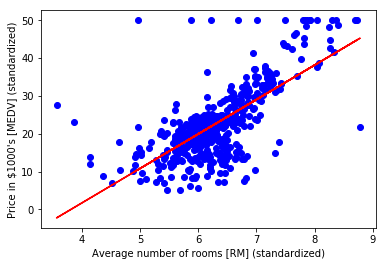

In [115]:
'''
plot a graph to compare with the results of our LinearRegression class
'''
p = lin_regplot(X, y, slr, 'plotting-sklearn-linear-reg')
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
plt.show()
plt.gcf().clear()

## Fitting a robust regression model using RANSAC
__RANdom SAmple Consensus (RANSAC)__ algorithm, fits a regression model to a subset of the data, the so-called _inliers_, thus eliminating the impact of _outliers_ on the prediction model.

In [93]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),
                        max_trials=100,
                        min_samples=50,
                        residual_metric=lambda x: np.sum(np.abs(x), axis=1),
                        residual_threshold=5.0,
                        random_state=0)
ransac.fit(X, y)

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/ransac.py:261: DeprecationWarning: 'residual_metric' was deprecated in version 0.18 and will be removed in version 0.20. Use 'loss' instead.
  DeprecationWarning)


RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_trials=100, min_samples=50, random_state=0,
        residual_metric=<function <lambda> at 0x7f49d1647f50>,
        residual_threshold=5.0, stop_n_inliers=inf, stop_probability=0.99,
        stop_score=inf)

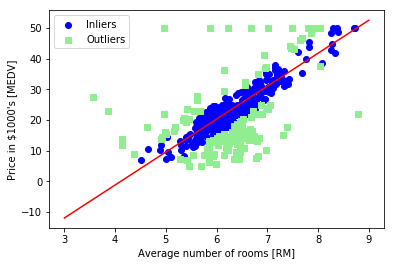

In [94]:
'''
plot the inliers and outliers obtained from RANSAC
'''
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper left')
plt.show()
# plt.savefig('./figures/ransac-plot.png', dpi=120)
plt.gcf().clear()

In [95]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089


## Evaluating the performance of linear regression models
We will now use all variables in the dataset and train a multiple regression model

In [96]:
'''
load data and train regressor
'''
from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.3, random_state=0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

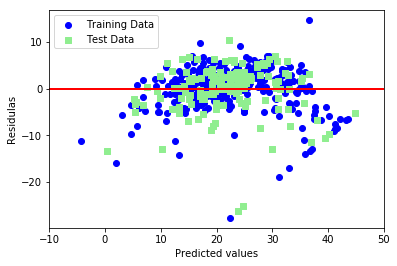

In [97]:
'''
Time to plot
------------

Since our model uses multiple explanatory variables, we can't visualize the linear
regression line in a two-dimensional plot, but we can plot the residuals versus the
predicted values to diagnose our regression model.
'''

plt.scatter(y_train_pred, y_train_pred - y_train,
           c='blue', marker='o', label='Training Data')
plt.scatter(y_test_pred, y_test_pred - y_test,
           c='lightgreen', marker='s', label='Test Data')
plt.xlabel('Predicted values')
plt.ylabel('Residulas')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.show()
# plt.savefig('./figures/preds-vs-residuals.png', dpi=120)
plt.gcf().clear()

## Training a linear regression into a curve - polynomial regression
We will now discuss how to use the PolynomialFeatures transformer class from scikit-learn to add a quadratic term ( d = 2 ) to a simple regression problem with one explanatory variable, and compare the polynomial to the linear fit.

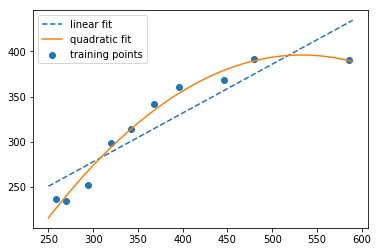

In [98]:
'''
testing polynomial regression
on random dummy data.
'''

# 1. Add a second degree polynomial term
from sklearn.preprocessing import PolynomialFeatures
X = np.array([258.0, 270.0, 294.0,
              320.0, 342.0, 368.0,
              396.0, 446.0, 480.0,
              586.0])[:, np.newaxis]
y = np.array([236.4, 234.4, 252.8,
              298.6, 314.2, 342.2,
              360.8, 368.0, 391.2,
              390.8])
lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

# 2. Fit a simple linear regression model for compqarison
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

# 3. Fit a multiple regression model on the transformed features for
#    polynomial regression:
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

# Plot the results
plt.scatter(X, y, label='training points')
plt.plot(X_fit, y_lin_fit,
        label='linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit,
        label='quadratic fit')
plt.legend(loc='upper left')
# plt.savefig('./figures/linear-vs-quad.png', dpi=120)
plt.show()
plt.gcf().clear()

In [99]:
'''
Finding MSE and R^2 score.
'''
from sklearn.metrics import mean_squared_error,\
                        r2_score
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
print('Training MSE linear: %.3f, quadratic: %.3f' % (
        mean_squared_error(y, y_lin_pred),
        mean_squared_error(y, y_quad_pred)))
print('Training R^2 linear: %.3f, quadratic: %.3f' % (
        r2_score(y, y_lin_pred),
        r2_score(y, y_quad_pred)))

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


## Modeling nonlinear relationships in the Housing Dataset
We will model the relationship between house prices and LSTAT (percent lower status of the population) using second degree (quadratic) and third degree (cubic) polynomials and compare it to a linear fit.

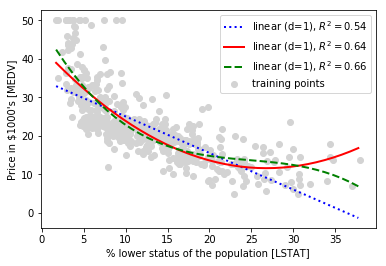

In [100]:
X = df[['LSTAT']].values
y = df['MEDV'].values
regr = LinearRegression()

# create polynomial features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# linear fit
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]
regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

# quadratic fit
regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quad_r2 = r2_score(y, regr.predict(X_quad))

# cubic fit
regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

# Plotting results
plt.scatter(X, y,
           label='training points',
           color='lightgray')
plt.plot(X_fit, y_lin_fit,
        label='linear (d=1), $R^2=%.2f$'%linear_r2,
        color='blue',
        lw=2,
        linestyle=':')
plt.plot(X_fit, y_quad_fit,
        label='linear (d=1), $R^2=%.2f$'%quad_r2,
        color='red',
        lw=2,
        linestyle='-')
plt.plot(X_fit, y_cubic_fit,
        label='linear (d=1), $R^2=%.2f$'%cubic_r2,
        color='green',
        lw=2,
        linestyle='--')
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper right')
# plt.savefig('./figures/polynomial-reg-plot.png', dpi=120)
plt.show()
plt.gcf().clear()

__Note:__ Polynomial features are not always the best choice for modelling nonlinear relationships.<br>
_For example_, just by looking at __MEDV-LSTAT__ scatterplot, we could propose that a log transformation of the __LSTAT__ feature and the square root of __MEDV__ may project the data onto a linear feature space suitable for linear regression fit.

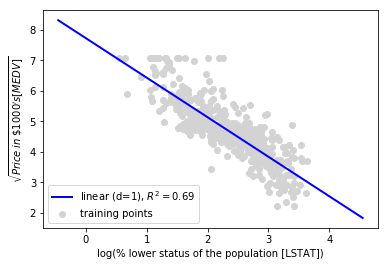

In [101]:
"""Let's test the above hypothesis"""
# transform features
X_log = np.log(X)
y_sqrt = np.sqrt(y)

# fit features
X_fit = np.arange(X_log.min() - 1,
                 X_log.max() + 1,
                 1)[:, np.newaxis]
regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

# plot results
plt.scatter(X_log, y_sqrt,
            label='training points',
            color='lightgray')
plt.plot(X_fit, y_lin_fit,
         label='linear (d=1), $R^2=%.2f$' % linear_r2,
         color='blue',
         lw=2)
plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000\'s [MEDV]}$')
plt.legend(loc='lower left')
plt.show()
# plt.savefig('./figures/log-sqrt-tranform-plot.png', dpi=120)
plt.clf()
plt.close('all')

## Decision tree regression
To use a decision tree for regression, we will replace entropy as the impurity measure of a node `t` by the MSE

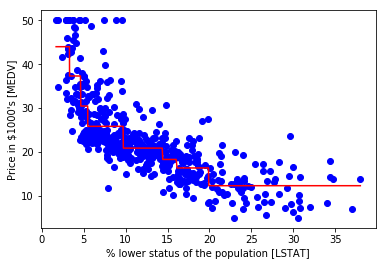

In [118]:
from sklearn.tree import DecisionTreeRegressor
X = df[['LSTAT']].values
y = df['MEDV'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.show()
# plt.savefig('./figures/decision-tree-regression.png', dpi=120)
plt.gcf().clear()

## Random forest regression
The random forest algorithm is an ensemble technique that combines multiple decision trees. A random forest usually has a better generalization performance than an individual decision tree due to randomness that helps to
decrease the model variance.

In [121]:
"""
let's use all the features in the Housing Dataset to fit a random forest regression model on 60 percent of the samples and evaluate its performance
on the remaining 40 percent.
"""
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                    test_size=0.4,
                    random_state=1)
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=1000,
                               criterion='mse',
                               random_state=1,
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

"""evaluating performance via MSE AND R^2 score"""
print('MSE train: %.3f, test: %.3f' % (
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
    r2_score(y_train, y_train_pred),
    r2_score(y_test, y_test_pred)))

MSE train: 1.642, test: 11.052
R^2 train: 0.979, test: 0.878


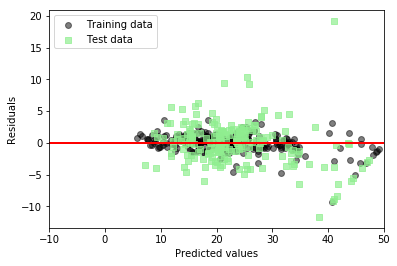

In [124]:
plt.scatter(y_train_pred,
    y_train_pred - y_train,
    c='black',
    marker='o',
    s=35,
    alpha=0.5,
    label='Training data')
plt.scatter(y_test_pred,
    y_test_pred - y_test,
    c='lightgreen',
    marker='s',
    s=35,
    alpha=0.7,
    label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.show()
# plt.savefig('./figures/random-forest-plot.png', dpi=120)
plt.gcf().clear()